# Recource Check

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [2]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from google_play_scraper import reviews_all, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt_tab')
try:
    stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Data Scrapping

In [4]:
from google_play_scraper import app, Sort, reviews_all

jkn_reviews = reviews_all(
    'id.okejack.okejackapp',
    sleep_milliseconds=0, # defaults to 0
    lang='id', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)
df_okejek = pd.DataFrame(np.array(jkn_reviews),columns=['content'])
df_okejek = df_okejek.join(pd.DataFrame(df_okejek.pop('content').tolist()))
df_okejek.to_csv(r'df_okejek', index=False)

adding sentiment_rating column

In [5]:
def get_sentiment(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'
df_okejek['sentiment_rating'] = df_okejek['score'].apply(get_sentiment)

# Data Pre-Processing

In [6]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
daftar_stopwords = set(stopwords.words('indonesian'))

In [7]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Punctual removal
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'(.)\1+', r'\1', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords Removal
    stopped_tokens = [word for word in tokens if word not in daftar_stopwords]

    # Detokenize
    text = " ".join(stopped_tokens)
    # Stemming
    text = stemmer.stem(text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
df_okejek['cleaned_content'] = df_okejek['content'].astype(str).fillna('').apply(preprocess_text)

## Finding and Removing Common Words

In [9]:
semua_teks = " ".join(ulasan for ulasan in df_okejek.cleaned_content if ulasan)
frekuensi_kata = Counter(semua_teks.split())
kata_terumum = frekuensi_kata.most_common(30)
print("30 Kata Paling Umum untuk Diperiksa:")
print(kata_terumum)

30 Kata Paling Umum untuk Diperiksa:
[('aplikasi', 932), ('driver', 696), ('oke', 662), ('nya', 640), ('yg', 397), ('mantap', 380), ('bagus', 372), ('jack', 349), ('gak', 305), ('order', 302), ('murah', 274), ('ok', 273), ('bantu', 270), ('ya', 266), ('drivernya', 254), ('okejek', 253), ('tolong', 250), ('ga', 249), ('moga', 214), ('baik', 205), ('pesan', 192), ('eror', 176), ('banget', 163), ('udah', 155), ('layan', 153), ('aja', 152), ('gk', 150), ('jek', 144), ('makan', 133), ('kasih', 129)]


In [10]:
manual_stopwords = ['aplikasi', 'driver', 'oke', 'jack','nya','yg','order','ok','ya','drivernya','moga','banget','layan','aja','makan']

def hapus_manual_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in manual_stopwords]
    return " ".join(filtered_tokens)

df_okejek['cleaned_content'] = df_okejek['cleaned_content'].apply(hapus_manual_stopwords)

## TF-IDF Vectorization

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df_okejek['cleaned_content'])
y = df_okejek['sentiment_rating']

# WorldCloud Visualization

Score Distribution

/tmp/ipython-input-4020058020.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette='viridis')


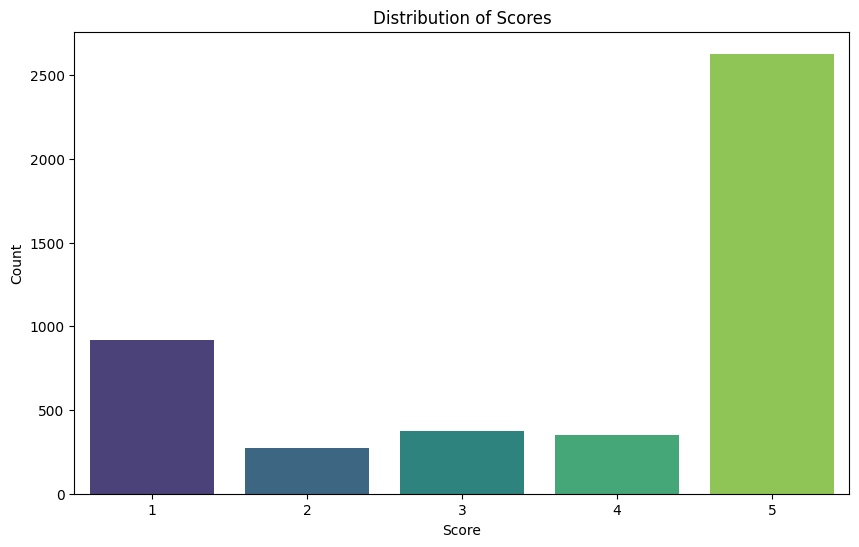

In [12]:
score_counts = df_okejek['score'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=score_counts.index, y=score_counts.values, palette='viridis')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Number of Reviews

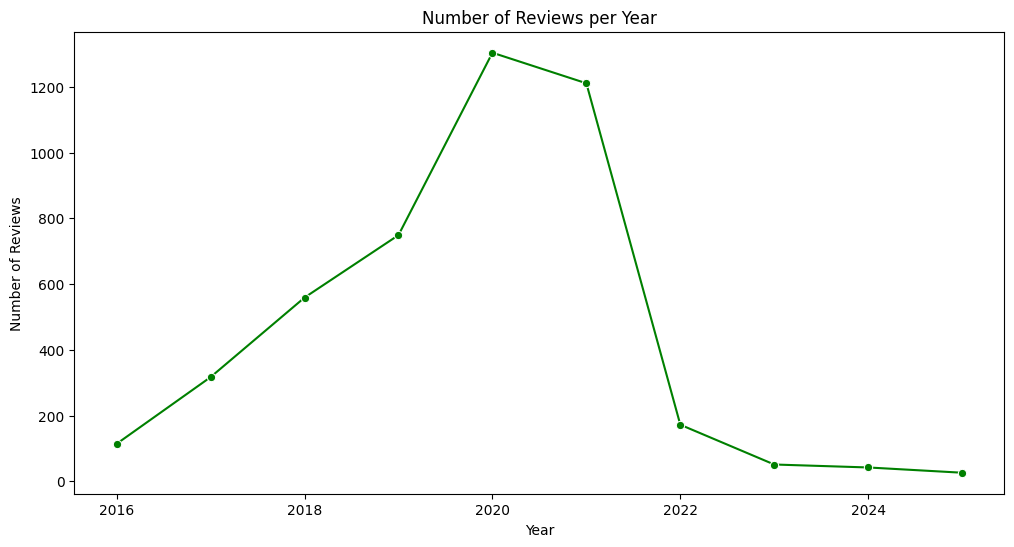

In [13]:
df_okejek['at'] = pd.to_datetime(df_okejek['at'])
df_okejek['year'] = df_okejek['at'].dt.year
year_counts = df_okejek['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color='green')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

wordcloud

In [14]:
from wordcloud import WordCloud

# Filter positive and negative reviews
positive_reviews = df_okejek[df_okejek['score'] >= 4]['cleaned_content'].dropna()
negative_reviews = df_okejek[df_okejek['score'] <= 3]['cleaned_content'].dropna()

# Combine all positive and negative reviews into single strings
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

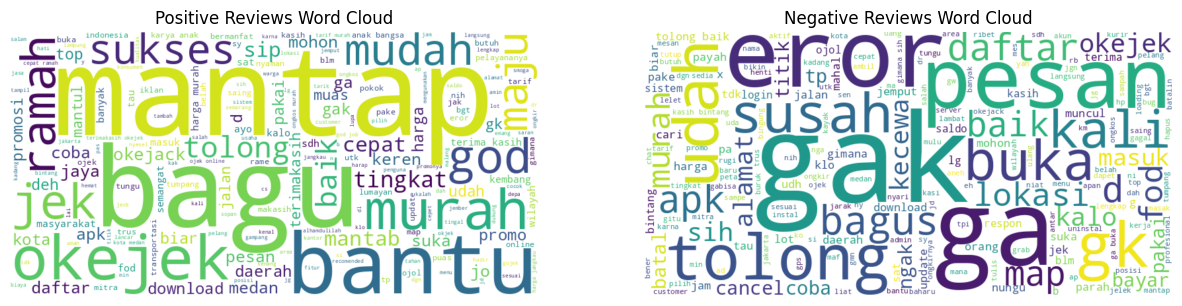

In [15]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()

# Sentiment Analysis Model Training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [20]:
y_pred = model.predict(X_test)
print("Akurasi Model:", accuracy_score(y_test, y_pred))
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred, zero_division=0))

Akurasi Model: 0.7942794279427943

Laporan Klasifikasi:
               precision    recall  f1-score   support

    Negative       0.73      0.65      0.69       231
     Neutral       0.00      0.00      0.00        78
    Positive       0.81      0.95      0.88       600

    accuracy                           0.79       909
   macro avg       0.52      0.53      0.52       909
weighted avg       0.72      0.79      0.75       909

